# Machine learning for football prediction

Rayan TALATE et Victor MICHEL

Dans ce notebook, nous allons chercher à prédire des résultats de matchs de football à partir de diverses caractéristiques, notamment les notes des joueurs sur la simulation de football FIFA.

# Import de la base de données et des modules indispensables

In [2]:
"""Tout d'abord, les modules:"""
from time import time
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import seaborn as sns
from scipy.stats import entropy
from functions_football import (win,get_match_outcome,get_last_matches,get_last_team_stats,get_last_matches_against_eachother,get_goals,
 get_goals_conceided,get_match_features,get_features)

In [4]:
"""Ensuite, la base de données, que l'on va lire grâce à pandas tout en utilisant la syntaxe SQL:"""
with sqlite3.connect('C:\\Users\\rayan\\Documents\\football prediction\\football-classification-predications-master\\Database sqlite\\database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    team_attributes = pd.read_sql_query("SELECT distinct * from Team_Attributes",con)
    player = pd.read_sql_query("SELECT * from Player",con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes",con)
df_italy = pd.read_csv('C:\\Users\\rayan\\Downloads\\df_italy.csv', error_bad_lines=False, sep =',',encoding = 'utf_8')
possessions_data = pd.read_csv('C:\\Users\\rayan\\Documents\\football prediction\\football-classification-predications-master\\Dataset\\possession_detail.csv')

DatabaseError: Execution failed on sql 'SELECT * from Country': no such table: Country

In [4]:
teams_stats = team_attributes
teams_stats.describe() #Pour avoir une vue d'ensemble de notre base de données.

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
count,1458.000000,1458.000000,1458.000000,1458.000000,489.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871
std,421.032659,39179.857739,13264.869900,11.545869,9.678290,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000
25%,365.250000,110.000000,8457.750000,45.000000,42.000000,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000
50%,729.500000,485.000000,8674.000000,52.000000,49.000000,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000
75%,1093.750000,1900.000000,9904.000000,62.000000,55.000000,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


In [5]:
shots_off = pd.read_csv("C:\\Users\\rayan\\Documents\\football prediction\\football-classification-predications-master\\dataset\\shotoff_detail.csv")
shots_on = pd.read_csv("C:\\Users\\rayan\\Documents\\football prediction\\football-classification-predications-master\\dataset\\shoton_detail.csv")
shots = pd.concat([shots_off[['match_id', 'team']], shots_on[['match_id', 'team']]])
total_matches = shots.drop_duplicates(['match_id', 'team'])["team"].value_counts()
#On compte le nombre de tirs par équipe:
shots = shots["team"].value_counts()
print(shots)

C:\Users\rayan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\rayan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,7,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


8455.0    4716
8650.0    4524
8586.0    4390
8456.0    4246
9825.0    4235
          ... 
2183.0      12
8245.0      11
8030.0      10
8398.0       9
9873.0       3
Name: team, Length: 178, dtype: int64


# Préparation des données

## Première étape: gestion des données manquantes.

Motivation: on a pu remarquer, dans le "describe" de teams_stats fait plus haut, que certaines colonnes manquent d'informations, notamment "buildUpPlayDribbling" qui n'a pas le même nombre d'observations que les autres colonnes. Il est donc nécessaire de gérer ces données manquantes pour ne pas avoir d'erreur dans les fonctions utilisées plus loin, et pour essayer de limiter le biais que ce manque de données crée.

Premièrement, nous travaillons sur les possessions et les matches en eux-mêmes:

In [6]:
last_possessions = possessions_data.sort_values(['elapsed'], ascending=False).drop_duplicates(subset=['match_id'])
last_possessions = last_possessions[['match_id', 'homepos', 'awaypos']]

In [7]:
"""On récupère les ID de home_team et away_team, ça nous servira plus tard."""
possessions = pd.DataFrame(columns=['team', 'possession', 'match'])
for index, row in last_possessions.iterrows():
    match = matches.loc[matches['id'] == row['match_id'], ['home_team_api_id', 'away_team_api_id']]
    if match.empty:
        continue
    hometeam = match['home_team_api_id'].values[0]
    awayteam = match['away_team_api_id'].values[0]
    possessions = possessions.append({'team': hometeam, 'possession': row['homepos'], 'match': row['match_id']}, ignore_index=True)
    possessions = possessions.append({'team': awayteam, 'possession': row['awaypos'], 'match': row['match_id']}, ignore_index=True)

total_possessions = possessions.groupby(by=['team'])['possession'].sum()
total_matches = possessions.drop_duplicates(['team', 'match'])["team"].value_counts()
    
#Remarque: cette cellule prend un peu de temps à s'exécuter.

On retire les colonnes qui ne nous intéressent pas:

In [8]:
matches =matches.drop(['IWH',
'IWD',
'IWA',
'LBH',
'LBD',
'LBA',
'PSH',
'PSD',
'PSA',
'WHH',
'WHD',
'WHA',
'SJH',
'SJD',
'SJA',
'VCH',
'VCD',
'VCA',
'GBH',
'GBD',
'GBA',
'BSH',
'BSD',
'BSA','BWH','BWD','BWA'],axis = 1 )

Puis on obtient les résultats de chaque match (pour l'équipe à domicile):

In [9]:
matches['result']  = matches[['home_team_goal', 'away_team_goal']].apply(win, axis=1)
print(matches['result'])

0        D
1        D
2        L
3        W
4        L
        ..
25974    W
25975    L
25976    W
25977    D
25978    W
Name: result, Length: 25979, dtype: object


Ensuite, on retire les matchs pouvant poser problème, et on range dans "home_teams" et "away_teams" les matchs à domicile et à l'extérieur.

In [10]:
matches = matches.dropna(inplace=False)

home_teams = matches['home_team_api_id'].isin(teams_stats['team_api_id'].tolist())
away_teams = matches['away_team_api_id'].isin(teams_stats['team_api_id'].tolist())

matches.describe()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,...,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A
count,13214.000000,13214.000000,13214.000000,13214.000000,1.321400e+04,13214.000000,13214.000000,13214.000000,13214.000000,13214.0,...,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000,13214.000000
mean,11110.432042,9528.298623,9528.298623,19.327380,1.275672e+06,9358.790601,9398.467988,1.554336,1.159830,1.0,...,102547.031179,95752.749584,91761.388906,103789.505827,104844.369532,99294.979718,93745.604510,2.621012,3.860472,4.716746
std,6951.053423,6901.753670,6901.753670,10.667404,4.839190e+05,6612.497403,7105.659946,1.299840,1.144863,0.0,...,110836.246033,107168.569582,105932.825953,114633.375796,114043.200928,108758.532844,104052.420984,1.809361,1.184474,3.852017
min,1729.000000,1729.000000,1729.000000,1.000000,4.890420e+05,4087.000000,4087.000000,0.000000,0.000000,1.0,...,2790.000000,2802.000000,2802.000000,2802.000000,2802.000000,2770.000000,2802.000000,1.040000,1.400000,1.080000
25%,6070.250000,4769.000000,4769.000000,10.000000,8.572878e+05,8533.000000,8533.000000,1.000000,0.000000,1.0,...,32569.000000,30889.000000,30682.000000,30985.000000,31921.000000,30924.000000,30893.000000,1.670000,3.300000,2.562500
50%,9594.500000,7809.000000,7809.000000,19.000000,1.239632e+06,8668.000000,8668.000000,1.000000,1.000000,1.0,...,41360.000000,39993.000000,39782.000000,41540.000000,41350.000000,40686.000000,40165.000000,2.100000,3.500000,3.500000
75%,13165.750000,10257.000000,10257.000000,28.000000,1.724056e+06,9874.000000,9874.000000,2.000000,2.000000,1.0,...,154938.000000,143757.000000,121695.250000,154949.000000,155623.000000,150565.000000,141161.000000,2.800000,4.000000,5.250000
max,24557.000000,21518.000000,21518.000000,38.000000,2.060645e+06,208931.000000,208931.000000,10.000000,9.000000,1.0,...,720738.000000,722766.000000,750435.000000,710807.000000,722766.000000,722766.000000,725718.000000,26.000000,17.000000,51.000000


Via ce describe, on peut voir qu'il n esemble pas y avoir de problèmes de valeurs manquantes sur ce DataFrame. Nous passons donc à l'autre DataFrame qui nous intéresse, à savoir teams_stats, pour lequel nous corrigeons les valeurs manquantes à travers la méthode de la mean imputation: on donne arbitrairement aux observations manquantes la valeur moyenne de la colonne.

In [11]:
"""Premier exemple de mean imputation: shots"""
for i, n in shots.iteritems():
    
    n_matches = total_matches[i]
    avg_shots = n / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == i, 'avg_shots'] = avg_shots
    
teams_stats['avg_shots'].describe()

count    997.000000
mean      10.794465
std        2.877979
min        3.000000
25%        9.500000
50%       10.437086
75%       11.397727
max       42.000000
Name: avg_shots, dtype: float64

Puisque le compte n'est pas de 1458, il y a des valeurs manquantes. Nous allons regarder l'histogramme de "avg_shots" pour s'assurer que la mean imputation a du sens, autrement dit, qu'il n'y a pas trop d'écart par rapport à la moyenne.

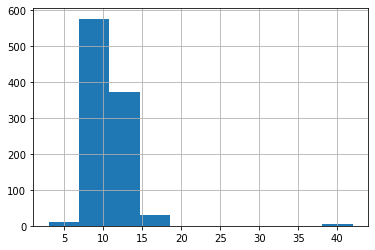

In [12]:
teams_stats['avg_shots'].hist()

L'histogramme nous indique que l'écart à la moyenne (qui est autour de 10,5 d'après le "describe" vu plus haut) est relativement restreint: la majorité des valeurs du DataFrame se trouvent entre 8 et 12. La mean imputation semble donc pertinente.

In [13]:
"""Mean imputation pour team stats"""
shots_avg_team_avg = teams_stats['avg_shots'].mean()
teams_stats.loc[(teams_stats['avg_shots'].isnull()), 'avg_shots'] = shots_avg_team_avg
teams_stats['avg_shots'].describe()

count    1458.000000
mean       10.794465
std         2.379510
min         3.000000
25%        10.000000
50%        10.794465
75%        11.000000
max        42.000000
Name: avg_shots, dtype: float64

On a désormais le bon nombre d'observations. Notons aussi que les quantiles se sont rapprochés de la moyenne, ce qui est naturel au vu de la méthode.
Nous allons désormais faire de même avec la colonne "buildUpPlayDribbling" de teams_stats.

In [14]:
teams_stats['buildUpPlayDribbling'].describe()

count    489.000000
mean      48.607362
std        9.678290
min       24.000000
25%       42.000000
50%       49.000000
75%       55.000000
max       77.000000
Name: buildUpPlayDribbling, dtype: float64

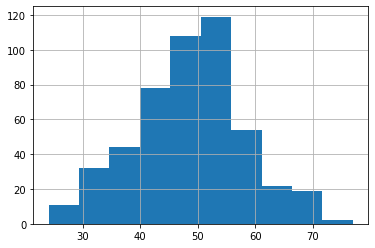

In [15]:
teams_stats['buildUpPlayDribbling'].hist()

L'histogramme nous indique que les valeurs sont plus étalées qu'auparavant. Nous allons tout de même faire une imputation, car l'étalement semble encore acceptable.

In [16]:
temp = teams_stats['buildUpPlayDribbling'].mean()
teams_stats.loc[(teams_stats['buildUpPlayDribbling'].isnull()), 'buildUpPlayDribbling'] = temp

## Deuxième étape: rajout des données des corners

Les corners sont des coups de pied arrêtés pouvant mener à des buts. Certaines équipes cherchent activement à s'en procurer afin d'essayer de marquer depuis cet événement de jeu. De ce fait, nous rajoutons les données liées aux corners afin d'affiner notre modèle.

In [17]:
corners_data = pd.read_csv("C:\\Users\\rayan\\Documents\\football prediction\\football-classification-predications-master\\Dataset\\corner_detail.csv")
corners = corners_data[['match_id', 'team']]

total_corners = corners["team"].value_counts()
total_matches = corners.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_corners in shots.iteritems():
    n_matches = total_matches[index]
    avg_corners = n_corners / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_corners'] = avg_corners
    
teams_stats.describe()

C:\Users\rayan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,997.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.794465,10.807166
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,2.379510,1.916837
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000,3.000000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,10.000000,9.700000
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.794465,10.591837
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,11.000000,11.526316
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,42.000000,21.000000


On remarque qu'il manque des données puisque le compte de "avg_corners" est inférieur à celui des autres colonnes. Cependant, nous estimons que le gain de précision lié à l'ajout des données de corners pour certains matchs est trop important pour laisser cette colonne de côté: nous allons donc utiliser à nouveau la technique de la mean imputation pour nous défaire de notre problème.

In [18]:
corners_avg_team_avg = teams_stats['avg_corners'].mean()
# mean imputation
teams_stats.loc[(teams_stats['avg_corners'].isnull()), 'avg_corners'] = corners_avg_team_avg
teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.794465,10.807166
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,2.379510,1.584839
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000,3.000000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,10.000000,10.119718
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.794465,10.807166
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,11.000000,11.105263
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,42.000000,21.000000


## Troisième étape: Rajout des données des centres

De même que les corners, les centres sont des événements pouvant mener à des buts et affectent donc substantiellement le résultat d'un match. Nous alons donc ajouter les données des centres dans notre DataFrame.

In [19]:
crosses_data = pd.read_csv("C:\\Users\\rayan\\Documents\\football prediction\\football-classification-predications-master\\Dataset\\cross_detail.csv")

crosses = crosses_data[['match_id', 'team']]
total_crosses = crosses["team"].value_counts()
total_matches = crosses.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_crosses in total_crosses.iteritems():
    n_matches = total_matches[index]
    avg_crosses = n_crosses / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_crosses'] = avg_crosses

teams_stats.describe()

C:\Users\rayan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (8,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners,avg_crosses
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,997.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.794465,10.807166,15.888237
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,2.379510,1.584839,2.815376
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000,3.000000,1.500000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,10.000000,10.119718,14.358974
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.794465,10.807166,15.750000
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,11.000000,11.105263,17.782895
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,42.000000,21.000000,27.000000


Il manque des valeurs, nous nous tournons donc encore vers la Mean imputation:

In [20]:
crosses_avg_team_avg = teams_stats['avg_crosses'].mean()
# mean imputation
teams_stats.loc[(teams_stats['avg_crosses'].isnull()), 'avg_crosses'] = crosses_avg_team_avg
teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners,avg_crosses
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.794465,10.807166,15.888237
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,2.379510,1.584839,2.327750
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000,3.000000,1.500000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,10.000000,10.119718,14.971448
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.794465,10.807166,15.888237
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,11.000000,11.105263,16.671053
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,42.000000,21.000000,27.000000


Nos  DataFrame "teams_stats" et "matches" sont désormais complets: nous pouvons essayer d'en visualiser les caractéristiques avant de se lancer dans une modélisation.

# Exploration et visualisation des données

Nous allons commencer par le dataframe "player_attributes", que nous n'avons pas vraiment pu appréhender pour l'instant.

In [21]:
player_attributes.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

On peut ranger les caractéristiques des joueurs en deux catégories: offensives, et défensives (les caractéristiques des gardiens, moins nombreuses, revêtent un intérêt moindre). Nous allons regarder les corrélations entre les caractéristiques d'une même catégorie:

In [22]:
lt_attacking_feature = ['crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping','penalties']

In [23]:
 corr = player_attributes[lt_attacking_feature].corr()

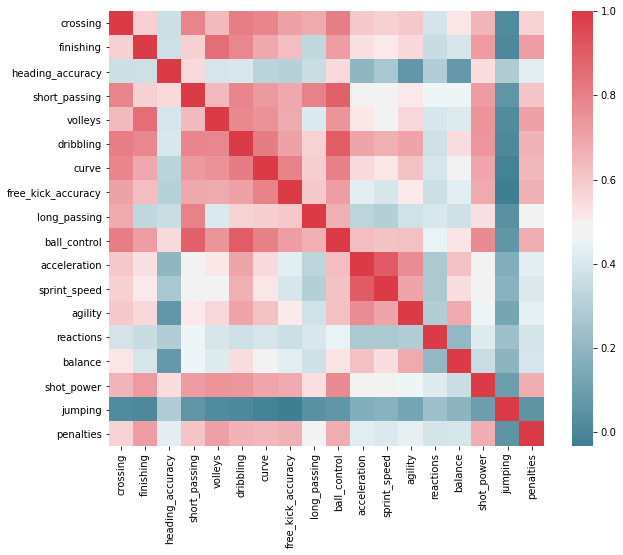

In [24]:
f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

L'on peut remarquer une réelle corrélation entre certaines variables, surtout dans le coin supérieur gauche de la heatmap. La plus grande corrélation se retrouve ependant entre "sprint_speed" et "acceleration": les deux variables étant étroitement liées à la vitesse d'un joueur, cela est compréhensible. De même, on observe une corrélation forte entre les statistiques liées au tir ("free_kick_accuracy","curve","finishing"). Ainsi, cette heatmap nous permet de visualiser que l'on a des sous-groupes de corrélations parmi les caractéristiques offensives.

Faisons de même pour les caractéristiques défensives, qui sont moins nombreuses.

In [25]:
lt_defense_feature = ['aggression', 'interceptions', 'positioning',
       'marking', 'standing_tackle', 'sliding_tackle']

In [26]:
corr_defence = player_attributes[lt_defense_feature].corr()

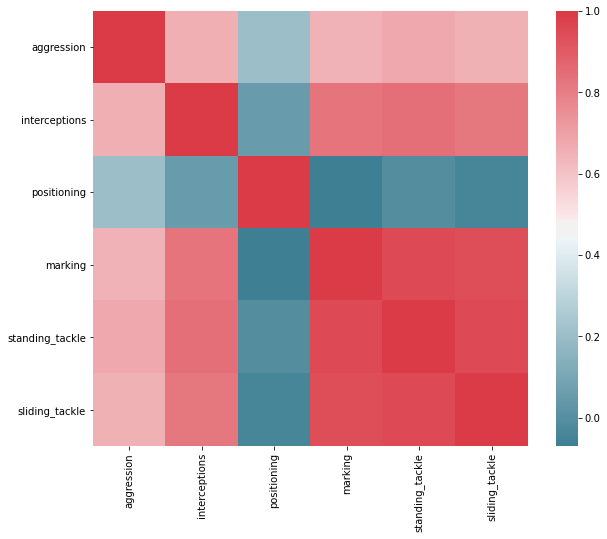

In [27]:
f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_defence, mask=np.zeros_like(corr_defence, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

L'on peut voir qu'à l'exception de "positioning", les attributs défensifs sont fortement corrélés entre eux, surtout sans le coin inférieur droit de la heatmap. Ces corrélations font sens: un défenseur qui est excellent tacleur le fait généralement aussi bien debout qu'en glissant. De même, les tacles nécessitant d'être proche de l'adversaire, il est logique qu'un bon tacleur soit aussi bon en marquage.

Visualisons désormais le DataFrame "player":

In [28]:
player.head(5)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


Le DataFrame contient peu d'informations; nous n'allons donc pas l'étudier en profondeur. Notons cependant qu'il nous permet de retrouver le nom d'un joueur à partir de sa fiche fifa, puisqu'il contient la colonne "player_fifa_api_id".

Regardons désormais s'il y a des valeurs nulles pour les dataframes précédemment étudiés:

In [29]:
player_attributes.isnull().sum(axis = 0 )

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

In [30]:
team_attributes.isnull().sum(axis = 0 )

id                                0
team_fifa_api_id                  0
team_api_id                       0
date                              0
buildUpPlaySpeed                  0
buildUpPlaySpeedClass             0
buildUpPlayDribbling              0
buildUpPlayDribblingClass         0
buildUpPlayPassing                0
buildUpPlayPassingClass           0
buildUpPlayPositioningClass       0
chanceCreationPassing             0
chanceCreationPassingClass        0
chanceCreationCrossing            0
chanceCreationCrossingClass       0
chanceCreationShooting            0
chanceCreationShootingClass       0
chanceCreationPositioningClass    0
defencePressure                   0
defencePressureClass              0
defenceAggression                 0
defenceAggressionClass            0
defenceTeamWidth                  0
defenceTeamWidthClass             0
defenceDefenderLineClass          0
avg_shots                         0
avg_corners                       0
avg_crosses                 

Team_attributes ne contient aucune valeur nulle, au contraire de "player_attributes". Remarquons cependant qu'à l'exception de la valeur "attacking_workrate", le nombre de valeurs manquantes est soit égal à 836, soit égal à 2713, ce qui laisse penser que les mêmes joueurs sont affectés par ces valeurs manquantes.
Cette fois, plutôt que d'utiliser la mean imputation, nous allons laisser les valeurs manquantes, et nous aviserons si leur manque nous pose un problème par la suite. En effet, il est possible que nous n'ayons pas besoin d'informations sur les joueurs concernés par les valeurs manquantes.

## Etude de cas: Les équipes ayant progressé entre 2011 et 2016.

Nous allons chercher à voir les équipes ayant le plus progressé d'un point de vue offensif et d'un point de vue défensif grâce à notre dataset.
Auparavant, nous effectuons quelques modifications sur "matches", et nous regardons quelques statistiques sur la saison 2015-2016 afin de se familiariser avec le dataset.

In [31]:
matches['league_id'] = matches['league_id'].replace(leagues['id'].to_list(),leagues['name'].to_list())
matches['away_name'] = matches['away_team_api_id'].replace(teams['team_api_id'].to_list(),teams['team_long_name'].to_list())
matches['home_name'] = matches['home_team_api_id'].replace(teams['team_api_id'].to_list(),teams['team_long_name'].to_list())

Text(0, 0.5, 'Leagues')

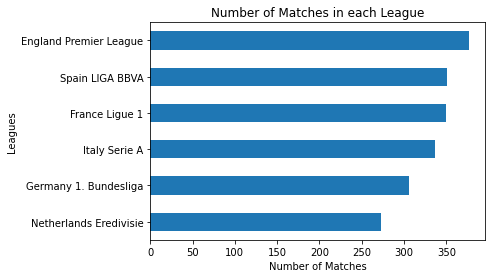

In [32]:
match_2016 = matches[matches['season'] == '2015/2016']
match_ = match_2016.groupby('league_id')['home_team_api_id'].count().sort_values()
match_.plot(kind='barh', title='Number of Matches in each League')
plt.xlabel('Number of Matches')
plt.ylabel('Leagues')

On remarque que les principaux championnats ne jouent pas le même nombre de matches.

Text(0, 0.5, 'Leagues')

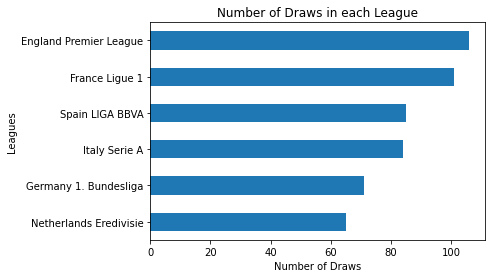

In [33]:
match_2016 = matches[(matches['season'] == '2015/2016')&(matches.result == 'D')]
match_ = match_2016.groupby('league_id')['home_team_api_id'].count().sort_values()
match_.plot(kind='barh', title='Number of Draws in each League');
plt.xlabel('Number of Draws')
plt.ylabel('Leagues')

Logiquement, le nombre de matches nuls n'est pas le même.

Comme nous avons un dataset qui s'étend sur 5 années, nous voulons voir les équipes ayant le plus progressé offensivement et défensivement parmi les 5 grands championnats étudiés.

In [34]:
#On récupère tous les matches de la saison 2015-2016, et les buts marqués en moyenne.
match_2016 = matches[(matches['season'] == '2015/2016')]
match_2016_away_goal = match_2016.groupby(['away_name'])['away_team_goal'].mean()
match_2016_home_goal = match_2016.groupby(['home_name'])['home_team_goal'].mean()

#On fait de même pour la saison 2010-2011
match_2011 = matches[(matches['season'] == '2010/2011')]
match_2011_away_goal = match_2011.groupby(['away_name'])['away_team_goal'].mean()
match_2011_home_goal = match_2011.groupby(['home_name'])['home_team_goal'].mean()

On fait ensuite la moyenne des buts marqués à domicile et à l'extérieur pour chaque équipe.

In [35]:
mean_11 = (match_2011_home_goal + match_2011_away_goal)/2
mean_16 = (match_2016_home_goal + match_2016_away_goal)/2
diff = mean_16 - mean_11

Enfin, on représente graphiquement la progression des joueurs:

In [36]:
color = []
def coloring(df):
        
        if df < 0:
            return 'red'
        else:
            return 'green'  
color= diff.sort_values().apply(coloring) 
#Une équipe qui progresse apparaîtra en vert, une équipe qui régresse, en rouge.

Improved teams :43


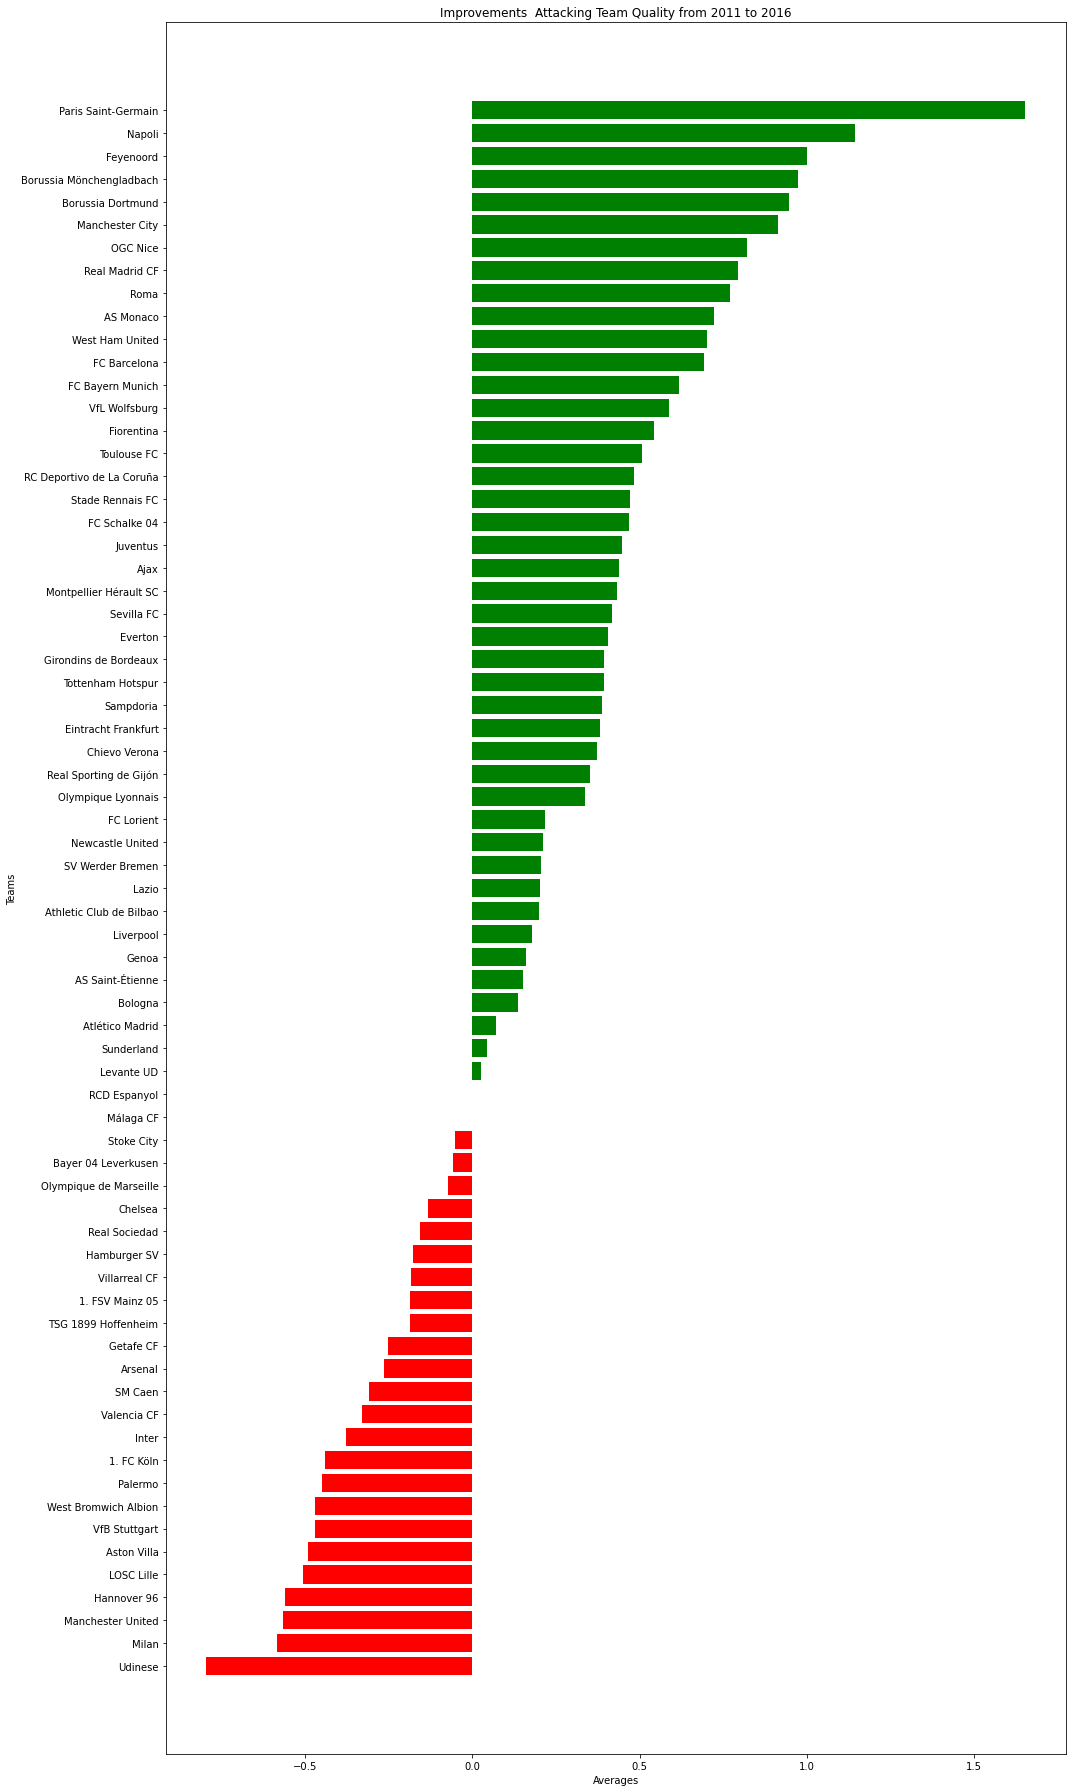

In [37]:
diff.dropna(inplace=True)
print('Improved teams :' + str(diff[diff.sort_values() > 0].count())) #On compte le nombre d'équipes ayant progressé.

# On classe les valeurs, de l'équipe ayant le plus progressé à l'équipe ayant le plus régressé:
sorted_index = diff.sort_values().index

fig, ax = plt.subplots(figsize=(15, 25))


plt.barh(range(0,len(sorted_index)), diff.sort_values(),color = color)


ax.set_yticks(range(0,len(sorted_index)))


ax.set_yticklabels(sorted_index)


ax.set_ylabel('Teams')


ax.set_title('Improvements  Attacking Team Quality from 2011 to 2016')


plt.xlabel("Averages")

plt.tight_layout()

Désormais, nous voulons regarder la même chose, mais du point de vue défensif:

In [38]:
match_2016_away_goal_against = match_2016.groupby(['away_name'])['home_team_goal'].mean()
match_2016_home_goal_against = match_2016.groupby(['home_name'])['away_team_goal'].mean()
match_2011 = matches[(matches['season'] == '2010/2011')]
match_2011_away_goal_against = match_2011.groupby(['away_name'])['home_team_goal'].mean()
match_2011_home_goal_against = match_2011.groupby(['home_name'])['away_team_goal'].mean()

In [39]:
mean_11_against = (match_2011_home_goal_against + match_2011_away_goal_against)/2
mean_16_against = (match_2016_home_goal_against + match_2016_away_goal_against)/2
diff_against = mean_16_against - mean_11_against

In [40]:
color = []
def coloring(df):
        
        if df < 0:
            return 'red'
        else:
            return 'green'  
color= diff_against.sort_values().apply(coloring) 

Improved teams :44


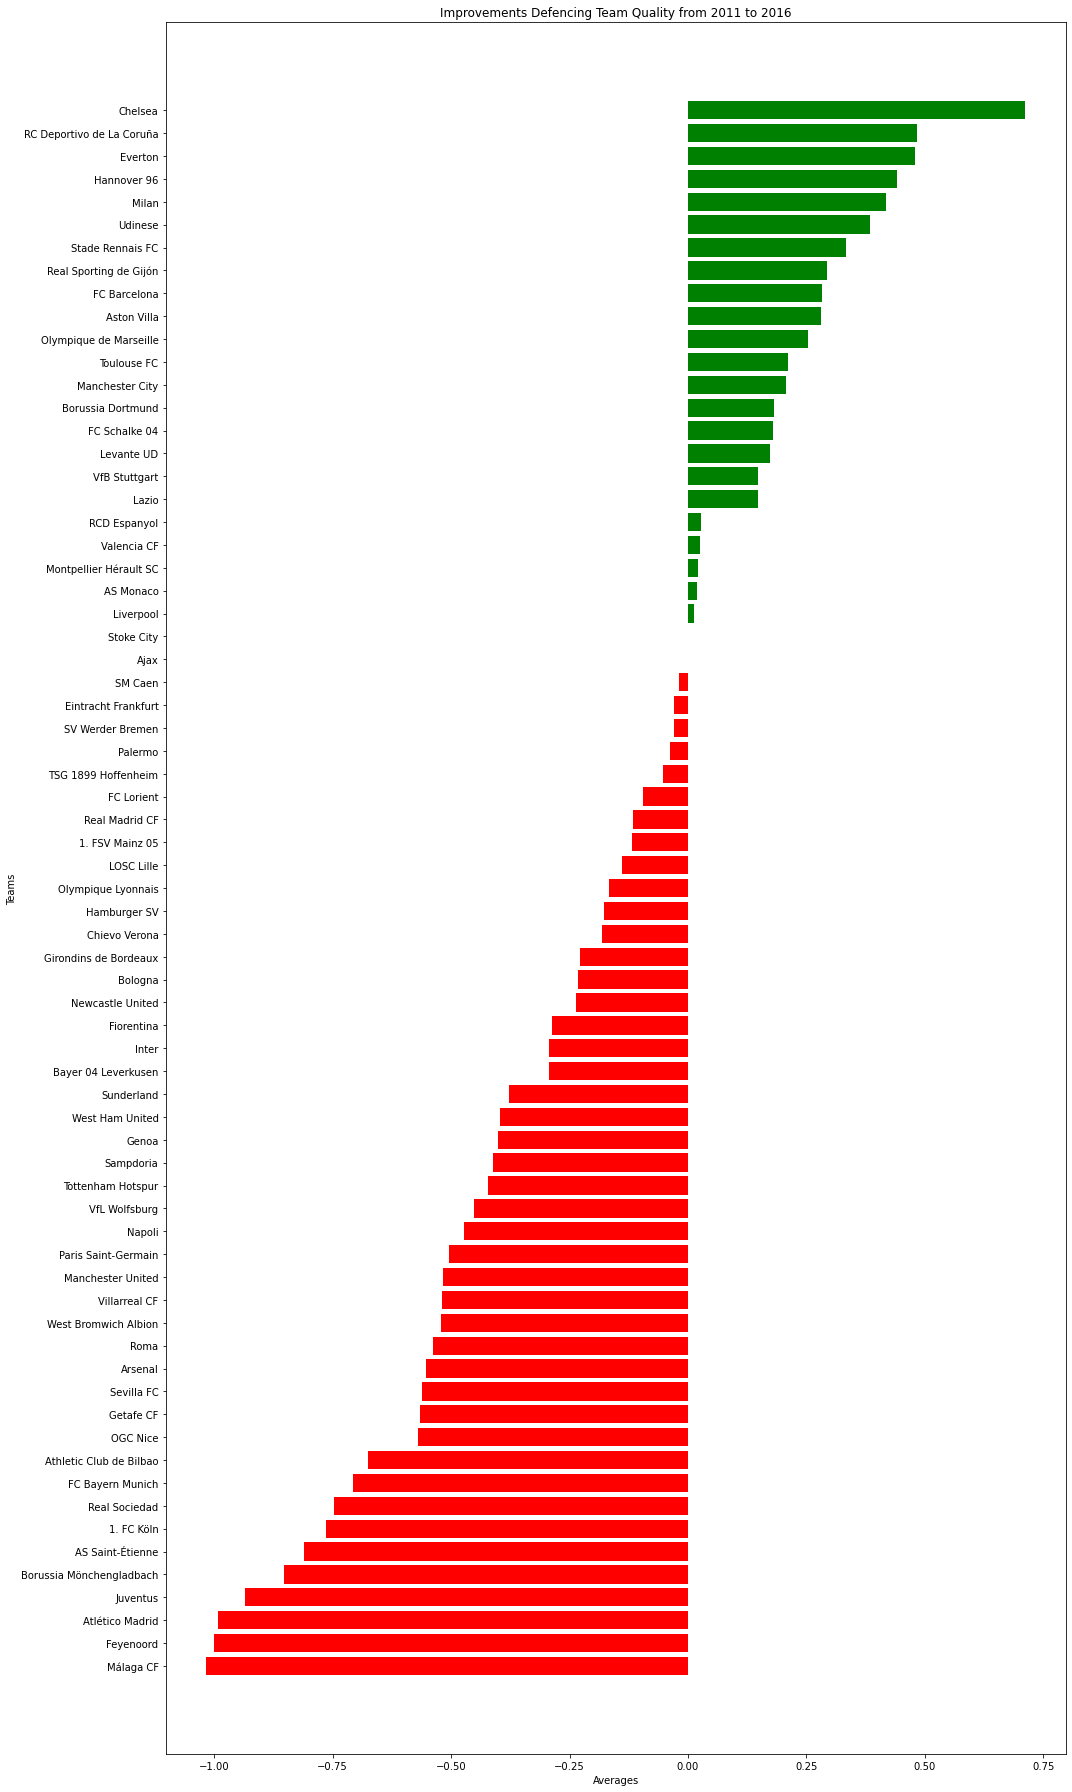

In [41]:
diff_against.dropna(inplace=True)
print('Improved teams :' + str(diff_against[diff_against.sort_values() < 0].count()))


sorted_index = diff_against.sort_values().index

fig, ax = plt.subplots(figsize=(15, 25))


plt.barh(range(0,len(sorted_index)), diff_against.sort_values(),color = color)


ax.set_yticks(range(0,len(sorted_index)))


ax.set_yticklabels(sorted_index)


ax.set_ylabel('Teams')


ax.set_title('Improvements Defencing Team Quality from 2011 to 2016')


plt.xlabel("Averages")

plt.tight_layout()

Désormais, nous regardons des résultats sur les championnats, autrement dit sur les différents pays. 
Premièrement, nous ajoutons le nombre de pays à leagues.

In [42]:
countries = countries.rename(columns = {1:'id','Belgium':'name'})
selected_countries = ['England','France','Germany','Italy','Spain']

countries = countries[countries.name.isin(selected_countries)]

leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))

In [43]:
subset = matches[matches.league_id.isin(leagues.name_y)]
subset = subset[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]

subset.dropna(inplace=True)


Nous allons considérer l'entropie des championnats sélectionnés, autrement dit leur prédictabilité, à partir des cotes de B365.

In [44]:


def match_entropy(row):

    odds = [row['B365H'],row['B365D'],row['B365A']]

    #On transforme les cotes, supérieures à 1, en probabilités

    probs = [1/o for o in odds]

    #On normalise pour avoir une somme qui vaut 1

    norm = sum(probs)

    probs = [p/norm for p in probs]

    return entropy(probs)



#On applique ensuite la fonction aux matches.

subset['entropy'] = matches.apply(match_entropy,axis=1)


In [45]:
subset['entropy']

1728     0.738980
1729     0.641186
1730     0.975928
1731     1.039730
1733     1.053487
           ...   
24552    0.931709
24553    1.080348
24554    0.907856
24555    1.084461
24556    1.078821
Name: entropy, Length: 12710, dtype: float64

On prend la moyenne, et on crée un dataset compréhensible puis qui pourra être représenté:

In [46]:
entropy_means = subset.groupby(['season','league_id']).entropy.mean()

entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')

entropy_means  = entropy_means[['England Premier League', 'France Ligue 1',
       'Germany 1. Bundesliga', 'Italy Serie A','Spain LIGA BBVA']]
entropy_means.rename(columns = {'England Premier League':'England','France Ligue 1':'France',
                                'Germany 1. Bundesliga':'Germany','Italy Serie A':'Italy',
                                'Spain LIGA BBVA':'Spain'})

entropy_means.head(10)

league_id,England Premier League,France Ligue 1,Germany 1. Bundesliga,Italy Serie A,Spain LIGA BBVA
season,,,,,
2008/2009,0.983154,NaN,1.002363,1.006269,1.013739
2009/2010,0.956528,NaN,0.997493,1.004651,0.981855
2010/2011,0.981499,1.020088,1.015570,1.004084,0.978555
2011/2012,0.969707,1.022392,1.001298,1.003220,0.956370
2012/2013,0.981472,1.014901,0.993993,1.003145,0.969854
2013/2014,0.960156,1.004041,0.977500,0.991617,0.944334
2014/2015,0.979916,1.014760,0.985835,0.997652,0.934518
2015/2016,0.997503,1.011497,0.974657,0.981996,0.945476


Text(7.75, 0.93, 'more predictable')

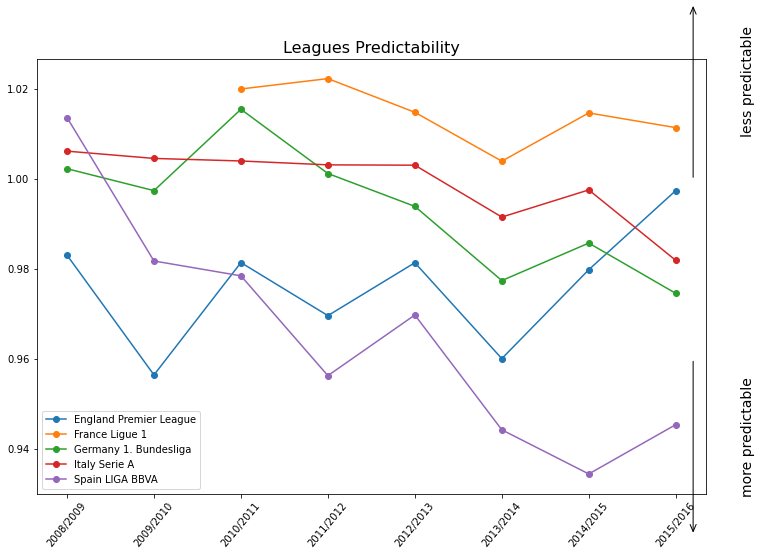

In [47]:
#Représentation graphique
ax = entropy_means.plot(figsize=(12,8),marker='o')


plt.title('Leagues Predictability', fontsize=16)

plt.xticks(rotation=50)

#On fixe les couleurs
colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(leagues.id,colors))

#On retire le label
ax.set_xlabel('')

plt.legend(loc='lower left')

#On utilise des flèches pour rendre le graphique plus lisible.
ax.annotate('', xytext=(7.2, 1),xy=(7.2, 1.039),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.2, 0.96),xy=(7.2, 0.921),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.75, 1.01), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.75, 0.93), annotation_clip=False,fontsize=14,rotation='vertical')

# Etude de cas: l'Italie. 
Nous allons observer la distribution des points et de la différence de buts pour la première division Italienne sur un certain nombre de saisons. Tout d'abord, observons le dataset:

In [1]:
df_italy.head()

NameError: name 'df_italy' is not defined

La colonne contient un certain nombre de colonnes. Regardons le nombre de saisons incluses dans le dataset grâce à "match_season" qui semble contenir les saisons pour lesquelles les points et la différence de buts de chaque équipe sont comptabilisées.

In [ ]:
season = matches['season' ].unique()
print(season)

Le dataset commence à la saison 2008/2009, et s'arrête à la saison 2015/2016. Nous allons donc observer sur cet intervalle de temps la distribution des points et des différences de buts pour les équipes engagées dans le championnat.

In [ ]:
df_italy.describe()

In [ ]:
#Visualisation de la distribution de points en Italie
plt.hist(df_italy['points'])
plt.title('Distribution of Points in Italy')
plt.xlabel('Points')
plt.ylabel('Frequency')

Commentaire: la plupart des équipes obtiennent entre 40 et 70 points. On retrouve là un résultat déjà lisible au travers des quantiles de la distribution, vus dans le "describe" plus haut. 
L'apprance de la distributions nous laisse penser que la distribution des points pourrait suivre une loi normale. C'est ce que nous allons vérifier:

In [49]:
stats.normaltest(df_italy['points'], axis=0)

La p-value du test de normalité est inférieur à 2%: il semble raisonnable de dire que la distribution de points suit une loi normale.
Observons désormais la corrélation entre les points et la différence de buts. Elle devrait être très élevée, puisque c'est en gagnant des matchs (donc en ayant une différence de buts positives) que l'on gagne des points.

In [51]:
corr = np.round(df_italy['points'].corr(df_italy['goals_difference']), decimals=2)

# plot le nuage de points
plt.scatter(df_italy['points'], df_italy['goals_difference'], label="Correlation Coefficient {}".format(corr));
plt.title('Scatterplot of Lost Matches and Goals Difference')
plt.xlabel('Points')
plt.ylabel('Goals Difference')
plt.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show();

Comme prévu, le coefficient de corrélation est très élevé: une bonne différence de buts s'accompagne presque toujours d'un nombre élevé de points.

In [52]:
plt.hist(df_italy['goals_difference'])
plt.title('Distribution of goal_difference in Italy')
plt.xlabel('Goal Diff')
plt.ylabel('Frequency')

L'histogramme est proche d'être centré en 0, et l'on observe un histogramme pouvant faire penser à une courbe en cloche, ce qui motive notre second test de normalité:

In [53]:
stats.normaltest(df_italy['goals_difference'], axis=0)

On observe une p_value encore plus basse que pour la distribution de points: il semblerait donc, encore une fois, que l'hypothèse de normalité soit plausible, cette fois à un niveau 1%.
Enfin, nous observons la distribution des points sur les saisons en question pour une équipe précise: la Juventus.

In [54]:
df_italy[df_italy.team == 'Juventus'].sort_values(by = 'match_season')['points']

L'on peut voir que les points de l'équipe ont beaucoup oscillé, allant de 55 à 102, soit presque du simple au double. Ainsi, il semblerait que la position de l'équipe ait été fluctuante sur ces dernières années.

Ceci conclut notre étude sur l'Italie. Nous allons désormais continuer notre travail principal, en récupérant les statistiques fifa des joueurs. 

# Récupération des statistiques FIFA.

Les commandes à venir pouvant parfois être longues, nous allons utiliser le module tqdm pour s'assurer que tout va bien.

In [58]:
pip install "tqdm>=4.9.0"

Note: you may need to restart the kernel to use updated packages.


In [59]:
from tqdm import tqdm

In [60]:
def get_fifa_stats(match, player_stats):
    ''' L'on agrège les statistiques fifa pour un match donné.'''    
    
    #On commence par définir et initialiser les variables:
    id_match =  match.match_api_id
    date = match['date']
    players = ['home_player_'+str(i) for i in range(1,12)] + ["away_player_" +str(i) for i in range(1,12)]
    player_stats_fifa = pd.DataFrame()
    names = []
    
    #On va effectuer plusieurs commandes pour chaque joueur:
    for player in players:   
            
        #Tout d'abord, on récupère les identifiants de chaque joueur.
        id_player = match[player]
        
        #L'identifiant nous sert à récupérer les statistiques du joueur:
        stats = player_stats[player_stats.player_api_id == id_player]
            
        #On récupère ensuite les statistiques actuelles du joueur (c'est-à-dire les statistiques avant que le match ne soit joué)    
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        current_stats.reset_index(inplace = True, drop = True)
        overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])

        #On change le nom de la statistique.
        name = str(player)+"_overall_rating"
        names.append(name)
        
            
        #On range le tout dans player_stats_fifa, notre sortie:
        player_stats_fifa = pd.concat([player_stats_fifa, overall_rating], axis = 1)
    
    player_stats_fifa.columns = names        
    player_stats_fifa['match_api_id'] = id_match

    player_stats_fifa.reset_index(inplace = True, drop = True)
    
    #En sortie,les statistiques fifa: 
    return player_stats_fifa.iloc[0]  

def get_fifa_data(matches, player_stats):
    '''On récupère les données fifa de chaque match. '''  
    #Puisque la fonction prend du temps, on utilise un petit print rappelant qu'il faut garder patience.
    print("Collecte des données fifa en cours, veuillez patienter quelques minutes")       
    tqdm.pandas()
    #On utilise la fonction précédente par chaque match
    fifa_data = matches.progress_apply(lambda x :get_fifa_stats(x, player_stats), axis = 1)
        
       
   
    
    #La fonction renvoie en sortie les données.
    return fifa_data

In [61]:
fifa_data = get_fifa_data(matches, player_attributes)

C:\Users\rayan\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|                                                                                        | 0/13214 [00:00<?, ?it/s]

Collecte des données fifa en cours, veuillez patienter quelques minutes


100%|████████████████████████████████████████████████████████████████████████████| 13214/13214 [09:44<00:00, 22.60it/s]


"Remarque: sachant que c'est d'assez loin la cellule la plus longue, je préconise de mettre fifa_data dans un csv."

Remarque: on peut trouver le fichier "fifa_data.csv" dans le dossier "dataset" du projet Github. Malheureusement, nous remarquions des différences dans les résultats qui rendaient nos modèles moins puissants. Nous préférons donc générer le résultat.

In [62]:
fifa_data.describe

<bound method NDFrame.describe of        home_player_1_overall_rating  home_player_2_overall_rating  \
1728                           85.0                          79.0   
1729                           75.0                          76.0   
1730                           78.0                          80.0   
1731                           77.0                          79.0   
1733                           79.0                          78.0   
...                             ...                           ...   
24552                          81.0                          81.0   
24553                          79.0                          75.0   
24554                          79.0                          80.0   
24555                          77.0                          71.0   
24556                          75.0                          77.0   

       home_player_3_overall_rating  home_player_4_overall_rating  \
1728                           88.0                          85.0   

# Création des DataFrame nécessaires à la classification.

Avant de nous lancer dans le vif du sujet, il nous faut obtenir les features, c'est-à-dire l'ensemble des données qui nous intéressent, les données des matches mais aussi les données FIFA.
Nous vous présentons ici les codes ayant permis d'obtenir les datasets utilisés. Pour des soucis d'efficacité, nous vous recommandons d'utiliser par la suite les .csv ("features.csv" pour features, "outcomes.csv" pour outcomes).

In [64]:
#Comment obtenir 'outcomes' et 'features':
viable_matches=pd.DataFrame(matches)


viable_matches = viable_matches.dropna(inplace=False) #On retire les valeurs NA.

teams_stats=pd.DataFrame(teams_stats)

home_teams = viable_matches['home_team_api_id'].isin(teams_stats['team_api_id'].tolist())
away_teams = viable_matches['away_team_api_id'].isin(teams_stats['team_api_id'].tolist())
viable_matches = viable_matches[home_teams & away_teams]

In [66]:
#Cette cellule-ci, particulièrement longue (plus de 10 minutes), est la raison pour laquelle nous avons sauvegardé nos résultats dans des csv.
viables = get_features(matches=viable_matches,teams_stats=teams_stats, fifa=fifa_data, x=10)

inputs = viables.drop('match_api_id', axis=1)
outcomes = inputs.loc[:, 'outcome']

C:\Users\rayan\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [67]:
from sklearn.preprocessing import Normalizer
features = inputs.drop('outcome', axis=1) #On retire les 'outcomes' de features, puisqu'on espère les deviner.
features.iloc[:,:] = Normalizer(norm='l1').fit_transform(features)
features.columns

Index(['home_team_buildUpPlaySpeed', 'home_team_buildUpPlayPassing',
       'home_team_chanceCreationPassing', 'home_team_chanceCreationCrossing',
       'home_team_chanceCreationShooting', 'home_team_defencePressure',
       'home_team_defenceAggression', 'home_team_defenceTeamWidth',
       'home_team_avg_shots', 'home_team_avg_corners', 'home_team_avg_crosses',
       'away_team_buildUpPlaySpeed', 'away_team_buildUpPlayPassing',
       'away_team_chanceCreationPassing', 'away_team_chanceCreationCrossing',
       'away_team_chanceCreationShooting', 'away_team_defencePressure',
       'away_team_defenceAggression', 'away_team_defenceTeamWidth',
       'away_team_avg_shots', 'away_team_avg_corners', 'away_team_avg_crosses',
       'home_team_goals_difference', 'away_team_goals_difference',
       'games_won_home_team', 'games_won_away_team', 'games_against_won',
       'games_against_lost', 'B365H', 'B365D', 'B365A',
       'League_England Premier League', 'League_France Ligue 1',
    

Nous allons regarder les corrélations qu'il y a dans features. Si les variables sont très corrélées, certaines approches (notamment la régression logistique) seront peut-être à exclure.

<function matplotlib.pyplot.show(*args, **kw)>

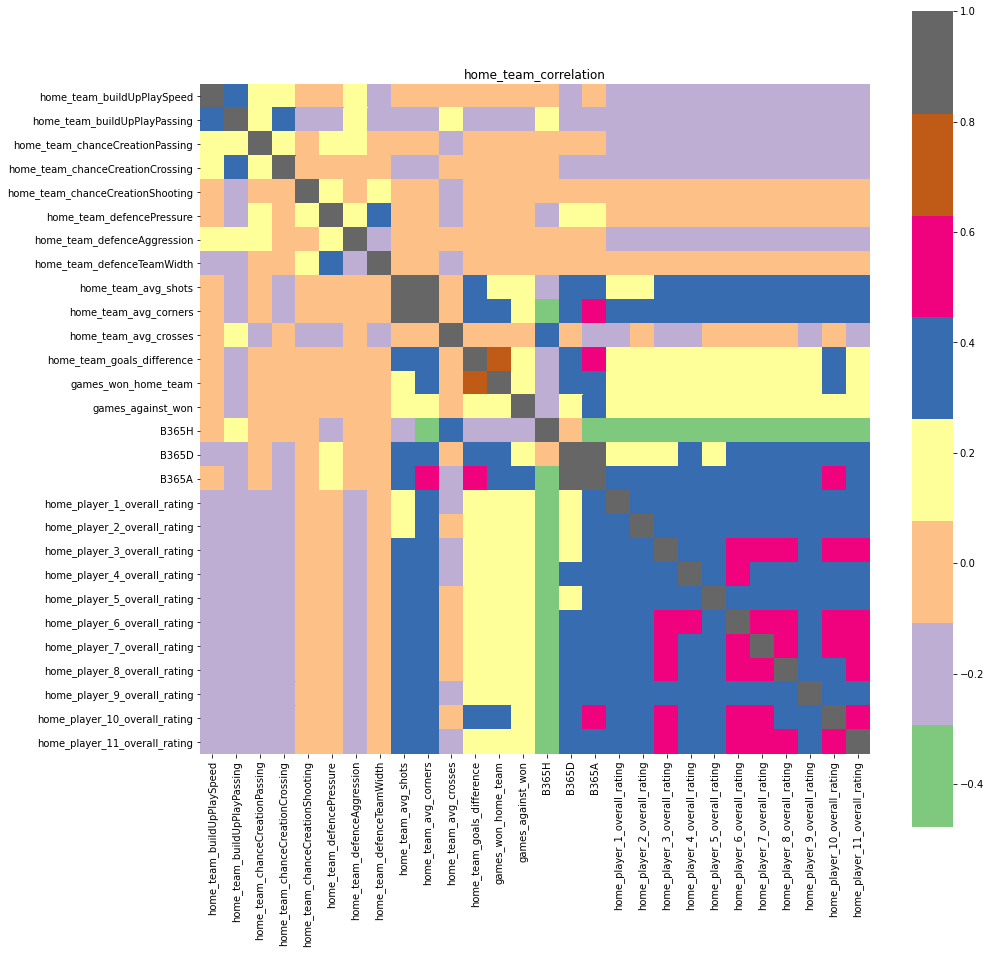

In [68]:
corr_test=features.drop(['League_England Premier League', 'League_France Ligue 1',
       'League_Germany 1. Bundesliga', 'League_Italy Serie A',
       'League_Netherlands Eredivisie', 'League_Scotland Premier League',
       'League_Spain LIGA BBVA','games_against_lost'],axis=1)

"""On va faire d'un côté les corrélations home_team, de l'autre les corrélations away_team
On peut raisonnablement supposer que ces deux clusters sont indépendants."""

corr_test_home=corr_test[corr_test.columns.drop(list(corr_test.filter(regex='away')))]

corr_test_away=corr_test[corr_test.columns.drop(list(corr_test.filter(regex='home')))]

corr_home=features[corr_test_home.columns].corr()

#corr=corr_test.corr()
#print(corr_test)
fig, ax = plt.subplots(figsize=(15,15))   
ax=plt.axes()
sns.heatmap(corr_home,square=True,ax=ax,cmap="Accent")
ax.set_title("home_team_correlation")
plt.show

On peut noter de fortes corrélations entre certaines variables, surtout entre la différence de buts et les buts marqués (ce que l'on avait déjà pu voir avec l'Italie auparavant). Les autres corrélations sont plus faibles, et l'on peut donc espérer pouvoir effectuer une régression.

Avant cela, une petite remarque: les dataFrame "features" et "outcomes" ont demandé du temps pour être obtenus. De ce fait, nous avons sauvegardé les DataFrames dans le dossier Github. Ils se nomment respectivement "features.csv" et "outcomes.csv". Nous nous en servirons plus tard.

# Modélisation

In [63]:
from sklearn.model_selection import GridSearchCV, KFold ,train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder



from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, precision_score, ConfusionMatrixDisplay, classification_report


## Première méthode: les K plus proches voisins

              precision    recall  f1-score   support

      Defeat       0.50      0.37      0.43       935
        Draw       0.40      0.03      0.06       842
         Win       0.53      0.88      0.66      1527

    accuracy                           0.52      3304
   macro avg       0.47      0.43      0.38      3304
weighted avg       0.49      0.52      0.44      3304



C:\Users\rayan\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['Win', 'Draw', 'Defeat'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


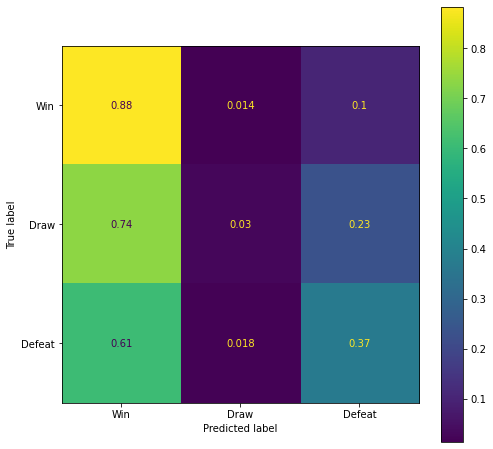

In [71]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=100)

Labels=["Win","Draw","Defeat"] #Les labels qui nous importent.

features_train,features_test,outcomes_train,outcomes_test=train_test_split(features,outcomes)
model.fit(features_train,outcomes_train)
pred_outcomes=model.predict(features_test)


print(classification_report(outcomes_test,pred_outcomes))
    
cm=confusion_matrix(outcomes_test,pred_outcomes,Labels,normalize="true")
cmdisp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=Labels)
fig, ax = plt.subplots(figsize=(8, 8))
cmdisp.plot(ax=ax)
plt.show()

L'on peut voir à travers la matrice de confusion que le modèle est très efficace pour prédire les victoires, mais beaucoup moins lorsqu'il est question de prédire les défaites, et tout bonnement médiocre pour les matches nuls. On remarque aussi que le modèle a tendance à beaucoup prédire les victoires, ce qui explique ses bons résultats pour les bonnes prédictions pour les victoires. Cela peut s'expliquer par la sur-représentation de victoires à domicile, et un poids sans doute trop grand donné à ce phénomène par le modèle.

## Deuxième modèle: les arbres de décisions.

              precision    recall  f1-score   support

      Defeat       0.36      0.38      0.37       913
        Draw       0.28      0.28      0.28       861
         Win       0.53      0.52      0.52      1530

    accuracy                           0.42      3304
   macro avg       0.39      0.39      0.39      3304
weighted avg       0.42      0.42      0.42      3304



C:\Users\rayan\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['Win', 'Draw', 'Defeat'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


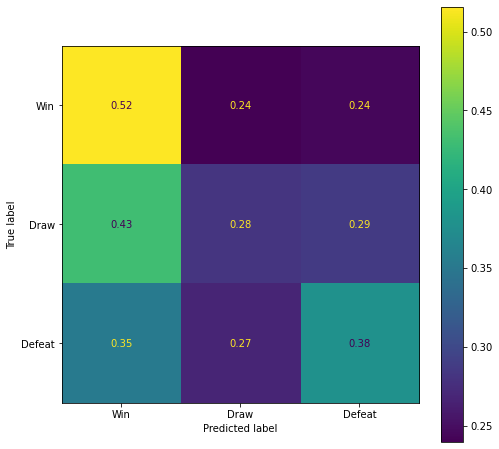

In [72]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion="entropy",random_state=0)#random state permet de fixer le résultat obtenu

Labels=["Win","Draw","Defeat"]

features_train,features_test,outcomes_train,outcomes_test=train_test_split(features,outcomes)
model.fit(features_train,outcomes_train)
pred_outcomes=model.predict(features_test)


print(classification_report(outcomes_test,pred_outcomes))
    
cm=confusion_matrix(outcomes_test,pred_outcomes,Labels,normalize="true")
cmdisp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=Labels)
fig, ax = plt.subplots(figsize=(8, 8))
cmdisp.plot(ax=ax)
plt.show()

Le modèle des arbres de décision a de plus mauvaises métriques, mais semble plus équilibré que son homologue des plus proches voisins. Il prédit correctement les matches nuls 10 fois(!) plus souvent, au détriment d'un score plus faible pour les victoires. Ici, il semblerait donc que le biais empirique des victoires à domicile ait été sous-estimé. Les scores pour les défaites sont, quand à eux, tout à fait semblables.

## Troisième modèle: le modèle Bayésien "Naïf"

              precision    recall  f1-score   support

      Defeat       0.47      0.56      0.51       913
        Draw       0.30      0.34      0.32       861
         Win       0.64      0.52      0.57      1530

    accuracy                           0.48      3304
   macro avg       0.47      0.47      0.47      3304
weighted avg       0.50      0.48      0.49      3304



C:\Users\rayan\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['Win', 'Draw', 'Defeat'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


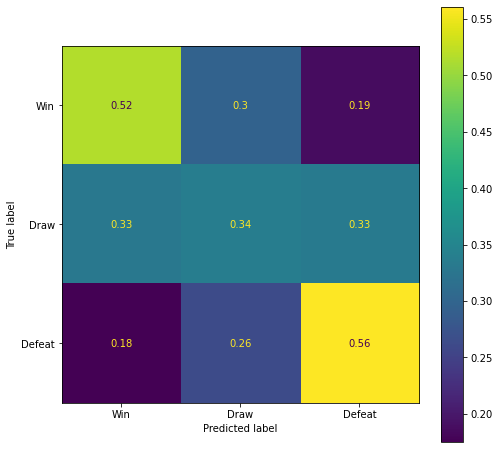

In [73]:
from sklearn.naive_bayes import GaussianNB

model=GaussianNB()
model.fit(features_train,outcomes_train)
pred_outcomes=model.predict(features_test)


print(classification_report(outcomes_test,pred_outcomes))
    
cm=confusion_matrix(outcomes_test,pred_outcomes,Labels,normalize="true")
cmdisp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=Labels)
fig, ax = plt.subplots(figsize=(8, 8))
cmdisp.plot(ax=ax)
plt.show()

Dans la lignée des arbres de décision, ce modèle présente des résultats bien plus équilibrés que le modèle des plus proches voisins, avec des résultats au-dessus de la moyenne pour les victoires ainsi que pour les défaites. Malheureusement, le score des matches nuls empêche les différentes métriques d'efficacité du modèle d'être vraiment satisfaisantes.

## Dernier modèle: la régression logistique.

Ce modèle nécessite un peu plus de manipulations pour pouvoir fonctionner:

              precision    recall  f1-score   support

      Defeat       0.00      0.00      0.00       953
        Draw       0.00      0.00      0.00       812
         Win       0.47      1.00      0.64      1539

    accuracy                           0.47      3304
   macro avg       0.16      0.33      0.21      3304
weighted avg       0.22      0.47      0.30      3304



C:\Users\rayan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rayan\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['Win', 'Draw', 'Defeat'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


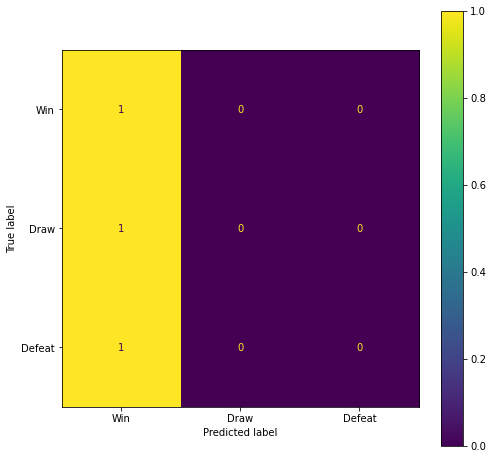

'cette cellule met beaucoup de temps, mais fonctionne.'

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
outcomes=pd.read_csv('C:\\Users\\rayan\\Documents\\football prediction\\football-classification-predications-master\\Dataset\\outcomes.csv')

model = LogisticRegression(multi_class='multinomial', solver='lbfgs',class_weight = 'balanced')
features_train,features_test,outcomes_train,outcomes_test=train_test_split(features,np.array(outcomes['outcome'].astype(str)))
model.fit(features_train,outcomes_train)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, features_train, outcomes_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

yhat = model.predict(features_test)

print(classification_report(outcomes_test,pred_outcomes))

pred_outcomes=yhat
cm=confusion_matrix(outcomes_test,pred_outcomes,normalize="true")
cmdisp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=Labels)
fig, ax = plt.subplots(figsize=(8, 8))
cmdisp.plot(ax=ax)
plt.show()





Commentaire: l'on se retrouve avec une "macro avg" toujous en-dessous de 0.5 (autrement dit, le classificateur se trompe plus de la moitié du temps), mais les résultats de défaite et de victoires restent satisfaisants. On se retrouve avec le même problème, à savoir que la prédiction des matches nuls est médiocre, ce qui explique le manque d'efficacité du modèle.

# Conclusion

Comme on peut le voir, nos modèles souffrent d'une précision faible,et ne prédisent pas de façon satisfaisante (au moins 50%) le résultat d'un match. Ce manque de précision était prévisible: notre base de données manquait de données qu'il a falllu imputer, et les données FIFA ne collent pas parfaitement à la réalité. Malgré tout, en omettant les prédictions de matches nuls, certains modèles parviennent à obtenir une précision notable pour les victoires et les défaites, ce qui laisse penser que ce système de prédiction revêt un intérêt malgré ses limites.